In [5]:
import pandas as pd
import numpy as np

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.float_format = '{:,.2f}'.format

from sklearn.model_selection import train_test_split

seed=42
np.random.seed = 42

In [6]:
def calculate_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with features removed
    '''
    const=add_constant(df)
    cols=const.columns
    variables=np.arange(const.shape[1])
    vif_df=pd.Series([variance_inflation_factor(const.values, i) 
               for i in range(const.shape[1])], 
              index=const.columns).to_frame()

    vif_df=vif_df.sort_values(by=0, ascending=False).rename(columns={0: 'VIF'})
    vif_df=vif_df.drop('const')
    vif_df=vif_df[vif_df['VIF'] > thresh]

    print('Features above VIF threshold:\n')
    print(vif_df[vif_df['VIF'] > thresh])

    col_to_drop = list(vif_df.index)

    for i in col_to_drop:
        print('Dropping: {}'.format(i))
        df = df.drop(columns=i)

    return 'done'

In [7]:
#columns
dtype_list = ['usableAreas','totalAreas','parkingSpaces','suites','bedrooms'
,'pricingInfos_price','pricingInfos_yearlyIptu','pricingInfos_monthlyCondoFee']

In [8]:
#reading
dataset = pd.read_csv('data/processed/train_cleaned.csv.gzip',compression='gzip', sep =';')
dataset[[x for x in dtype_list]] = dataset[[x for x in dtype_list]].astype('float')

dataset['interestingFlag'] = dataset['interestingFlag'].map({True:1, False:0}).astype('float')

In [9]:
#olhando as features 
_=dataset.address_neighborhood.nunique()/dataset[dataset.usableAreas!=0].shape[0]
print(f'razão: # de bairros/# de linhas = {_:.2f}')

razão: # de bairros/# de linhas = 0.02


In [10]:
_=dataset[dataset.usableAreas==0]['id'].count()/dataset.shape[0]
print(f'razão: # de área igual à 0/# de linhas = {_:.2f}')

razão: # de área igual à 0/# de linhas = 0.29


### olhando a colireariedade, nos dados contínuos
e torcendo

In [12]:
aux_list = ['usableAreas','parkingSpaces','suites','bedrooms'
,'pricingInfos_yearlyIptu','pricingInfos_monthlyCondoFee']
aux_df=dataset[(dataset['usableAreas']>0)&(dataset['pricingInfos_yearlyIptu']>0)
               &(dataset['pricingInfos_monthlyCondoFee']>0)]

calculate_vif_(aux_df[aux_list],5)

Features above VIF threshold:

Empty DataFrame
Columns: [VIF]
Index: []


'done'

Perceba que não há nada colinear, uhul

In [13]:
dataset['usableAreas_flg']=dataset['usableAreas'].apply(lambda x: 1 if x>0 else 0)
dataset['interestingFlag']=dataset['interestingFlag'].apply(lambda x: 1 if x else 0)
dataset.interestingFlag.fillna(0, inplace=True)

#### Train/test

In [14]:
from sklearn import preprocessing

dataset=dataset[(dataset['usableAreas']>10)&(dataset['pricingInfos_price']<1000000)]
dataset=pd.get_dummies(dataset, columns=["address_zone"])

x_col=['usableAreas', 'parkingSpaces', 'suites', 'bedrooms'
,'bathrooms', 'pricingInfos_yearlyIptu', 'pricingInfos_monthlyCondoFee','interestingFlag'
, 'address_zone_Centro','address_zone_Zona Leste','address_zone_Zona Oeste', 'address_zone_Zona Sul']

x=dataset[x_col]
y=dataset['pricingInfos_price']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

x_train_sc = preprocessing.scale(x_train)
x_test_sc = preprocessing.scale(x_test)

#### Regression

In [15]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error,mean_absolute_error

_x = sm.add_constant(pd.DataFrame(x_train_sc, columns=x_col))
est = sm.OLS(pd.DataFrame(y_train.values, columns=['price']), _x)
est = est.fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     4221.
Date:                Wed, 14 Oct 2020   Prob (F-statistic):               0.00
Time:                        12:12:49   Log-Likelihood:            -3.7531e+05
No. Observations:               28372   AIC:                         7.506e+05
Df Residuals:                   28359   BIC:                         7.508e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                          4.35e+05    798.678    544.593      0.000    4.33e+05    4.37e+05
usableAreas                   4.965e+04   1102.744     45.028      0.000    4.75e+04    5.18e+04
parkingSpaces                 2.744e+04   1090.872     25.154      0.000    2.53e+04    2.96e+04
suites                        3.194e+04   1140.177     28.013      0.000    2.97e+04    3.42e+04
bedrooms                      7596.1320   1051.503      7.224      0.000    5535.135    9657.129
bathrooms                     3.555e+04   1164.554     30.530      0.000    3.33e+04    3.78e+04
pricingInfos_yearlyIptu       3.931e+04    836.579     46.994      0.000    3.77e+04     4.1e+04
pricingInfos_monthlyCondoFee   6.22e+04    953.675     65.220      0.000    6.03e+04    6.41e+04
interestingFlag               8063.6504    802.121     10.053      0.000    6491.455    9635.846
address_zone_Centro           3.939e+04    972.632     40.497      0.000    3.75e+04    4.13e+04
address_zone_Zona Leste       8894.7570   1051.261      8.461      0.000    6834.235     1.1e+04
address_zone_Zona Oeste       3.871e+04   1010.983     38.286      0.000    3.67e+04    4.07e+04
address_zone_Zona Sul         4.702e+04   1134.687     41.437      0.000    4.48e+04    4.92e+04
==============================================================================
Omnibus:                     2717.639   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18611.023
Skew:                           0.178   Prob(JB):                         0.00
Kurtosis:                       6.952   Cond. No.                         3.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
_ = sm.add_constant(pd.DataFrame(x_test_sc, columns=x_col))
y_pred = est.predict(exog=_)

mse =mean_squared_error(y_test, y_pred,squared=False)
mae=mean_absolute_error(y_test, y_pred)
print(f'mse:{mse}\nmae:{mae}')

mse:138632.79745920165
mae:99991.84538587806


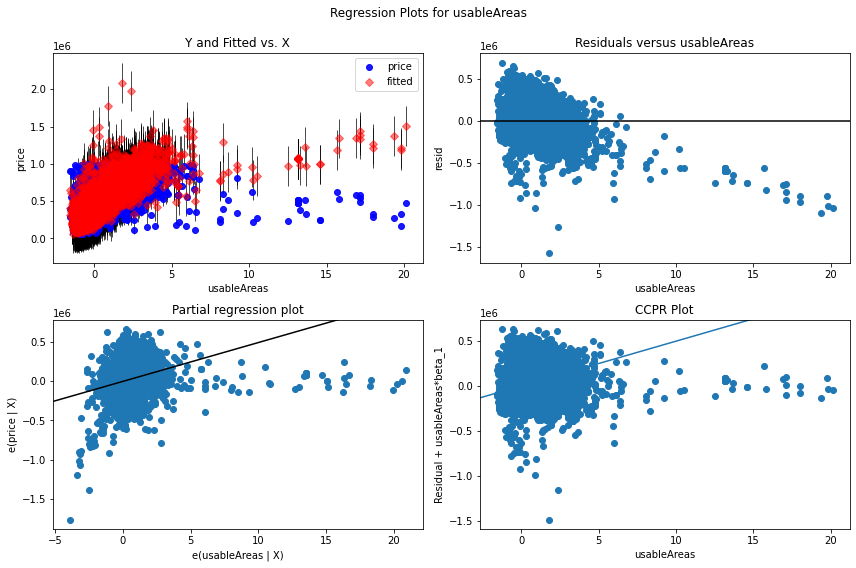

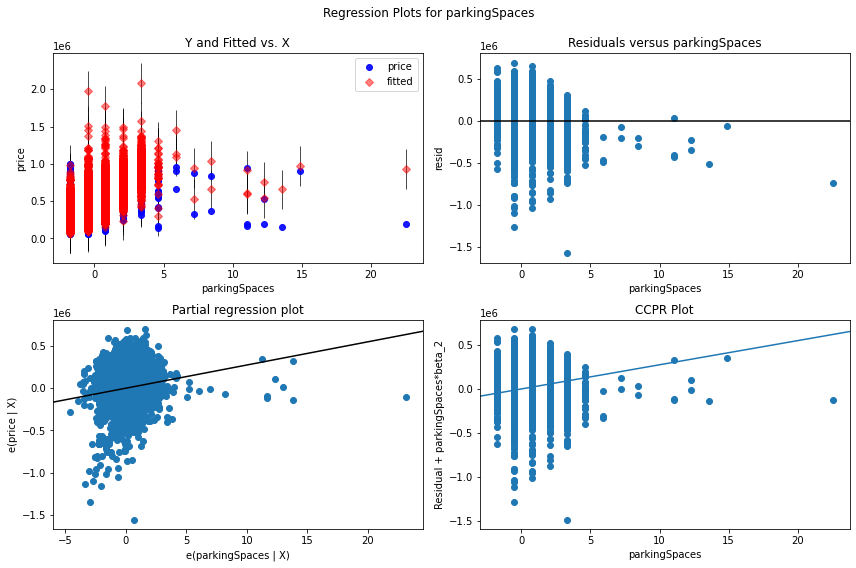

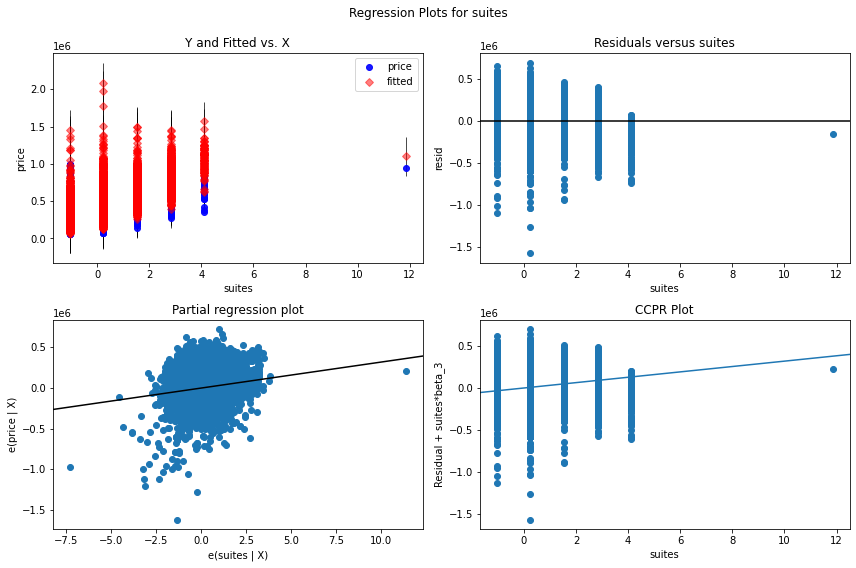

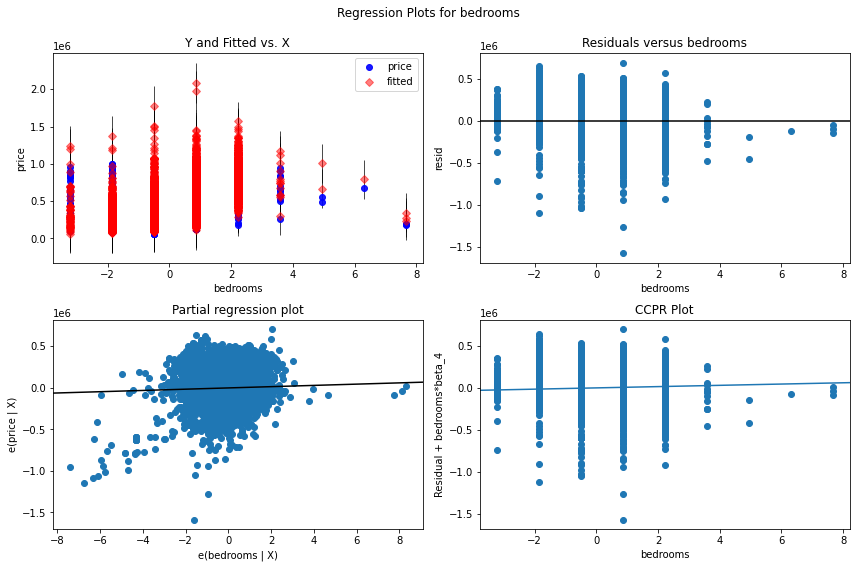

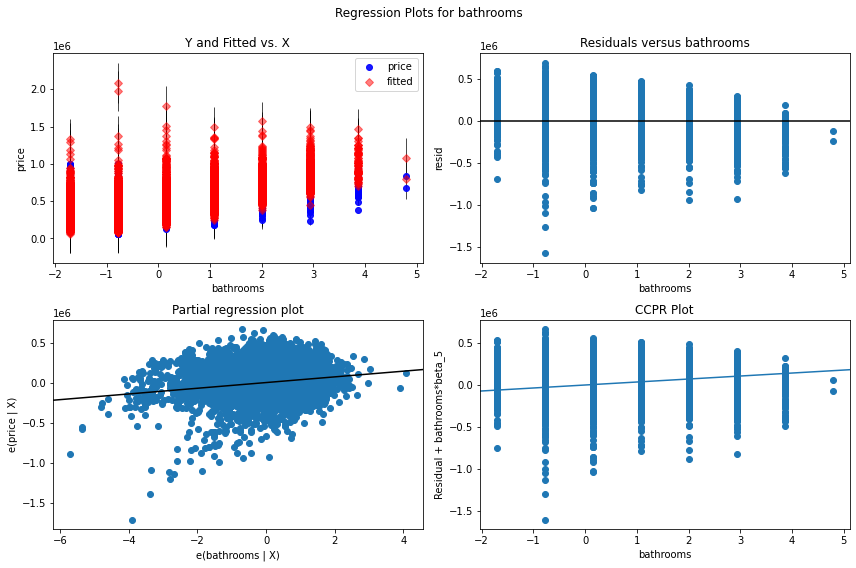

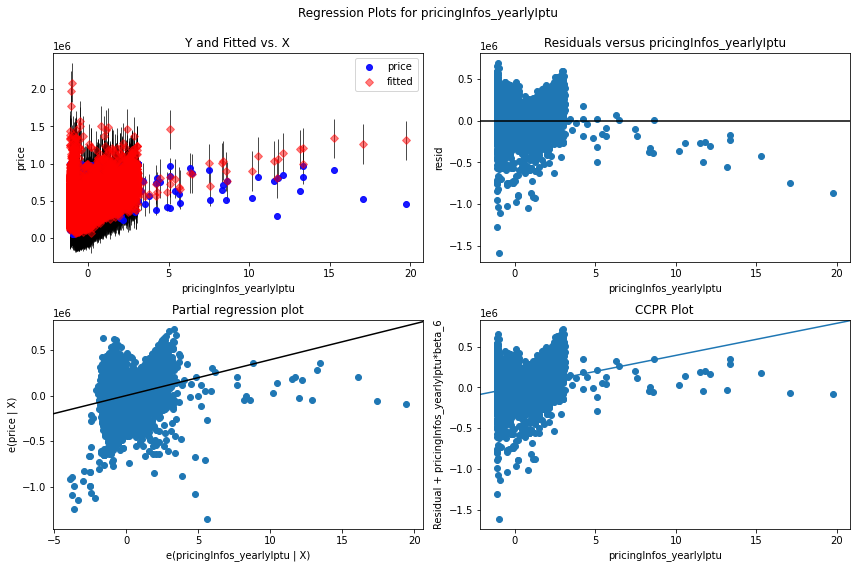

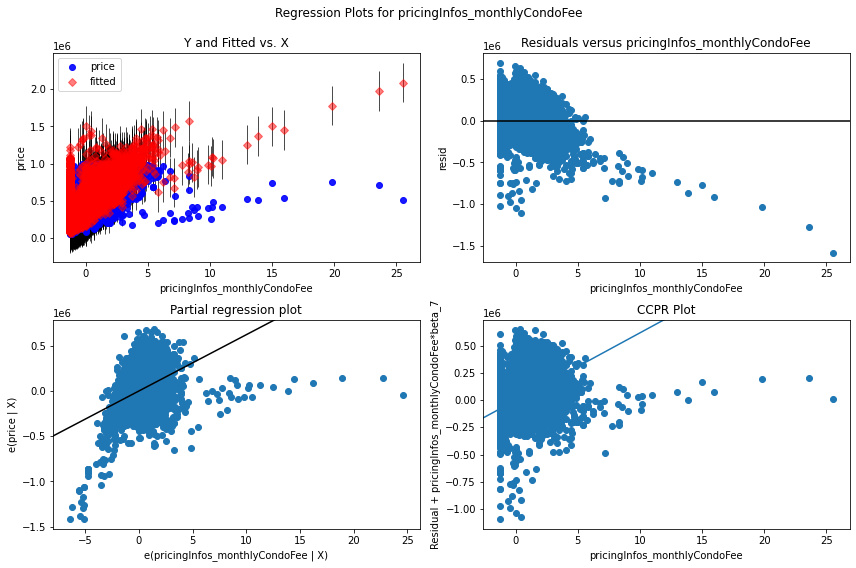

In [17]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

res_list=['usableAreas', 'parkingSpaces', 'suites', 'bedrooms'
,'bathrooms', 'pricingInfos_yearlyIptu', 'pricingInfos_monthlyCondoFee']

for i in res_list:
    fig = plt.figure(figsize=(12,8))
    fig = sm.graphics.plot_regress_exog(est, i, fig=fig)

#### conclusão

Percebemos que o MAE e MSE ficaram um pouco grande
Os resíduos deram uma estourada quanto maior o valor da var. explicativa.
Assim, acredito que um pouco mais de pré-processing seria um bom caminho assim como dividir o modelo em mais faixas de menor de preço. 

Regression - RF

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

n_estimators=[20,50,60,100]
max_features=['auto','sqrt','log2']
max_depth=[2,5,9,13,18,24,26]
min_samples_split=[2,5,7,10]
min_samples_leaf=[6,8,12,18]

paramns={'n_estimators':n_estimators,
'max_features':max_features,
'max_depth':max_depth,
'min_samples_split':min_samples_split,
'min_samples_leaf':min_samples_leaf
}
rfg = RandomForestRegressor(random_state=seed)
rfg_cv=RandomizedSearchCV(estimator=rfg
                         ,param_distributions=paramns
                         ,cv=10
                         ,n_jobs=-1
                         ,random_state=seed)

rfg_cv = rfg_cv.fit(x,y)

In [19]:
mse=mean_squared_error(y_test, rfg_cv.predict(x_test),squared=False)
mae=mean_absolute_error(y_test, rfg_cv.predict(x_test))
print(f'mse:{mse}\nmae:{mae}')

mse:66953.61017085977
mae:37310.87359606236


In [21]:
"""
rfg_cv.best_params_ ={'n_estimators': 100,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_features': 'log2',
 'max_depth': 24}
"""
rfg_2=RandomForestRegressor(n_estimators=100
,min_samples_split=5,min_samples_leaf=6
,max_features='log2' ,max_depth=24 ,random_state=seed).fit(x,y)

In [22]:
pd.DataFrame(data={'importance':rfg_2.feature_importances_
             ,'name':x.columns.values})

,importance,name
0,0.29,usableAreas
1,0.09,parkingSpaces
2,0.05,suites
3,0.03,bedrooms
4,0.10,bathrooms
5,0.23,pricingInfos_yearlyIptu
6,0.19,pricingInfos_monthlyCondoFee
7,0.00,interestingFlag
8,0.00,address_zone_Centro
9,0.01,address_zone_Zona Leste


#### conclusão
esse modelo apresenta performance bem mais interessante e é muito mais fácil de explicar para o usuário final, na medida que o feat importance é muito intuitivo.

In [23]:
import pickle
pickle.dump(rfg_2, open('model/RandomForestRegressor.sav', 'wb'))